## Load modules  

In [18]:
from influxdb import InfluxDBClient
from matplotlib import pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from pytz import timezone
import numpy as np

## Sensor node depth data

In [13]:
# set up the lists(node_id and length between node and bottom)
node_id_list=['Bridge1','Bridge2','Bridge3','Bridge4','Bridge5']
length_ntb_list =[3911.6, 3175, 4927.6, 4978.4, 3556]
ntb_df=pd.DataFrame(length_ntb_list, columns=['depth'])
ntb_df=ntb_df.set_index([node_id_list])

#set up the influxDBClient 
client_dict = {'host' : 'ec2-3-91-156-8.compute-1.amazonaws.com',
               'port' : 8086,
               'username' : 'generic_node',
               'password' : 'GlareShellTwilight',
               'database' : 'RAW'}

client = InfluxDBClient(**client_dict)

# definition of query to call influxdb data
def run_query(client, field, measurement, tags, pagesize=10000):
    
    #select the length of node to bottom  
    length_ntb=ntb_df.at[tags['node_id'],'depth']
    
    collect = []
    times = []
    values = []
    q = True
    pagenum = 0
    # Single quotes around tags might not always work
    tag_str = ' AND '.join(["{key}='{value}'".format(key=key, value=value) for key, value
                            in tags.items()])
    
    
    while q:
        q = client.query(("SELECT {field} FROM {measurement} WHERE {tags} "
                          "LIMIT {pagesize} OFFSET {page}")
                          .format(field=field, measurement=measurement, tags=tag_str,
                                  pagesize=pagesize, page=pagenum*pagesize))
        if q:
            collect.append(q[measurement])
           
        pagenum += 1
    for resultset in collect:
        for reading in resultset:
            dt_gmt=pd.Timestamp(reading['time'],tz='Etc/GMT')
            times.append(dt_gmt)
            values.append((length_ntb-reading[field])*0.001)
            
    s = pd.Series(values, index=times)
    s.index = pd.to_datetime(s.index)
    
    
    drop_index=s[s<=0].index
    s=s.drop(index=drop_index)


    return s




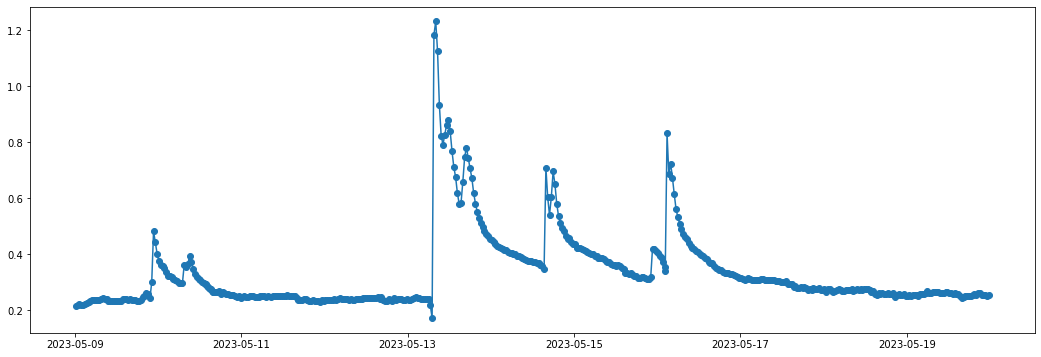

In [14]:
#plot graph  
fig, ax = plt.subplots(figsize=(18, 6))
start_date='20230509 00:00:00'
end_date='20230520 00:00:00'


s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge3'})
x3=s[start_date:end_date]
t_b3 =s[start_date:end_date].index
plt.plot(t_b3,x3,'o-', label='Bridge3')


## Forecasted precipitation -Tomorrow API

In [26]:

# Simulation params
sample_interval = 30

#set client and inital parameter
client = InfluxDBClient(host='ec2-13-58-107-29.us-east-2.compute.amazonaws.com',username='ewre_student',password='happylife!',database='tomorrow_api' )
# Set time
start = datetime(2023, 4, 1, 0, 0, 0, tzinfo=timezone('US/Central'))
end = datetime(2023, 5, 25, 0, 0, 0, tzinfo=timezone('US/Central'))

# Convert to UTC time
start_time = start.astimezone(timezone('UTC')).strftime("%Y-%m-%dT%H:%M:%SZ")
end_time = end.astimezone(timezone('UTC')).strftime("%Y-%m-%dT%H:%M:%SZ")

# Collect precipitation probability
query = f"SELECT rainIntensity FROM weather_forecast WHERE location ='30.2871667, -97.7341111' AND time >= '{start_time}' AND time <= '{end_time}'"
now_result = client.query(query)

forecast_precip=np.array([],dtype='f')
forecast_time=np.array([],dtype='str')
for reading in now_result:
    for data in reading:
        forecast_precip=np.append (forecast_precip,data['rainIntensity'])
        forecast_time=np.append (forecast_time,data['time'])

forecast_time=np.array(forecast_time, dtype='datetime64[s]')
forecast_precip=pd.DataFrame(forecast_precip/60, index=forecast_time,columns=['precip_tot__in'])

forecast_precip['dt__s'] = np.roll(pd.Series(forecast_precip.index).diff(1).dt.seconds.values, -1)

# Compute precipitation rate from total inches and dt
forecast_precip['precip_rate__in_per_s'] = forecast_precip['precip_tot__in'] / forecast_precip['dt__s']


/var/folders/0z/96nhv68546j11lkz0bh80tqw0000gp/T/ipykernel_35982/3392805156.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  forecast_time=np.array(forecast_time, dtype='datetime64[s]')


<AxesSubplot:>

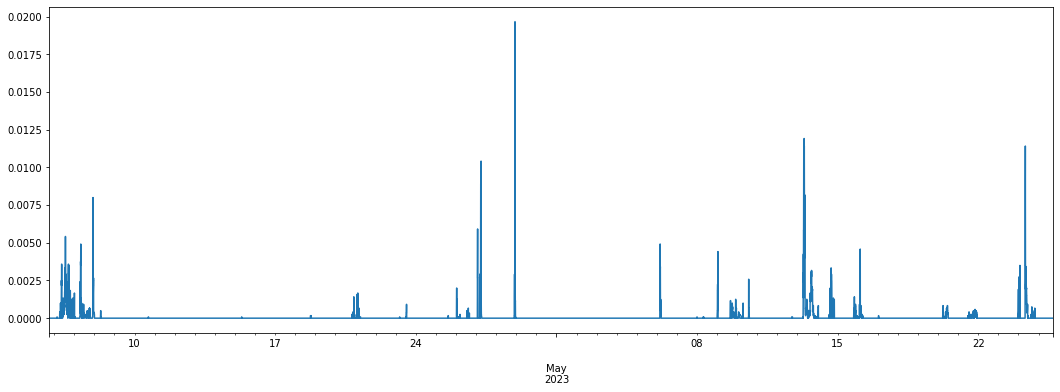

In [27]:
#plot graph  
fig, ax = plt.subplots(figsize=(18, 6))
precip__in.plot()


## Save Data

In [28]:

# forecast_precip.to_csv('../data/rainfall_data/precip__in_forecast.csv')